# Simple Model 1

In [247]:
%load_ext autoreload
%autoreload 2
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import geopandas
import geopy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium.plugins as plugins
import math
from math import sin, cos, sqrt, atan2, radians
from haversine import haversine
from itertools import combinations
%matplotlib inline
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 200)
from useful_functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
df = pd.read_csv('cleaned_data.csv')
len(df)

15851

In [87]:
# create a simple linear model with just one independent variable
# As single feature need to reshape X_train into column vector
df1 = df.copy()
X_train = np.array(df1['SqFtTotLiving']).reshape(-1,1)
y_train = df1['SalePrice']

In [88]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                 1.010e+04
Date:                Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                        19:32:43   Log-Likelihood:            -2.2843e+05
No. Observations:               15851   AIC:                         4.569e+05
Df Residuals:                   15849   BIC:                         4.569e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9291.9955   8504.112     -1.093      0.275    -2.6e+04    7377.030
x1           374.8940      3.730    100.509      0.000     367.583     382.205
==============================================================================
Omnibus:                    19945.027   Durbin-Watson:                   0.685
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          9825842.224
Skew:                           6.470   Prob(JB):                         0.00
Kurtosis:                     124.284   Cond. No.                     5.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ok so there are issues with this model of course, only a single feature has been used. It still manages to explain 39% of the variance in SalePrice, which I'm actually surprised at - this suggests the total square footage of living space is an important factor in house prices - perhaps this is less surprising!

C:\Users\Andrew\Documents\Flatiron\Course\phase_2\project\110920-pt-phase-2-project\useful_functions.py:69: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


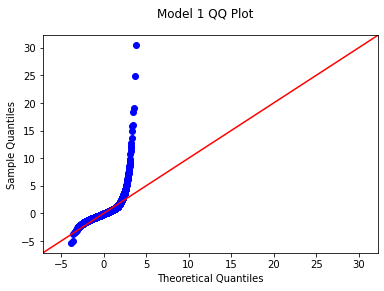

In [89]:
get_qq(model, 'Model 1')

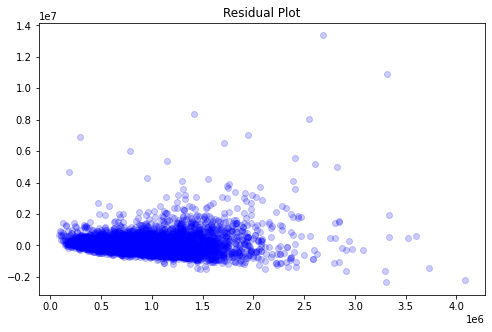

In [90]:
get_resid(df1, model)

In [91]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg.fit(X_train, y_train)

scores = cross_val_score(
            linreg, 
            X_train,
            y_train,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores = np.sqrt(-scores)
display(rmse_scores)
display(rmse_scores.mean())
display(rmse_scores.std())

array([ 273996.8099302 ,  262073.65662739,  298476.26954476,
        306525.03804902,  290063.51526738,  256734.93056669,
        270496.02301345,  273578.29343339,  330007.16912153,
       1424165.40108199])

398611.71066358173

342506.0943804986

In [107]:
# Define table as a dataframe with specific columns. Each column's values will be a list that we will add to.
summary = pd.DataFrame({'Model': [], 'Description':[], ' No. Features' : [], 'R^2':[],
                                'Adj R^2':[], 'RMSE': [],'RMSE sd':[], 'JB':[]})

# Add data for simple linear regression
summary.loc[0] = ['Simple Model - one independent variable', 'Square ft Total living', model.df_model, round(model.rsquared,3)\
                  , round(model.rsquared_adj,3), int(rmse_scores.mean()), int(rmse_scores.std()), round((sms.jarque_bera(model.resid)[0]),0)]

summary

,Model,Description,No. Features,R^2,Adj R^2,RMSE,RMSE sd,JB
0,Simple Model - one independent variable,Square ft Total living,1.0,0.389,0.389,398611.0,342506.0,9825842.0


It is pretty clear that this model violates the assumptions that residuals are normally distributed. This is also reflected with the extremely high JB number. The mean squared error is also very high, 398,611USD meaning that on average the house price predicted by the model could be +/- 400k USD away from the actual value - not the best. 

I will remove outliers from this model to try and improve these metrics.

# Simple Model 2 (outliers removed)

In [110]:
df2 = df.copy()
df2 = drop_outliers(df2, 'SalePrice', 3)
df2 = drop_outliers(df2, 'SqFtTotLiving', 3)

In [111]:
X_train2 = np.array(df2['SqFtTotLiving']).reshape(-1,1)
y_train2 = df2['SalePrice']

In [112]:
X_int2 = sm.add_constant(X_train2)
model2 = sm.OLS(y_train2, X_int2).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     8444.
Date:                Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                        20:26:43   Log-Likelihood:            -2.1568e+05
No. Observations:               15411   AIC:                         4.314e+05
Df Residuals:                   15409   BIC:                         4.314e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.671e+05   6371.126     26.230      0.000    1.55e+05     1.8e+05
x1           272.4155      2.965     91.893      0.000     266.605     278.226
==============================================================================
Omnibus:                     2916.013   Durbin-Watson:                   0.678
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7132.340
Skew:                           1.055   Prob(JB):                         0.00
Kurtosis:                       5.579   Cond. No.                     5.87e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\Andrew\Documents\Flatiron\Course\phase_2\project\110920-pt-phase-2-project\useful_functions.py:66: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


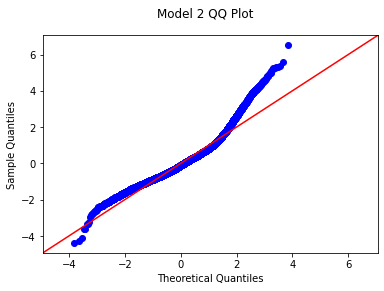

In [113]:
get_qq(model2, 'Model 2')

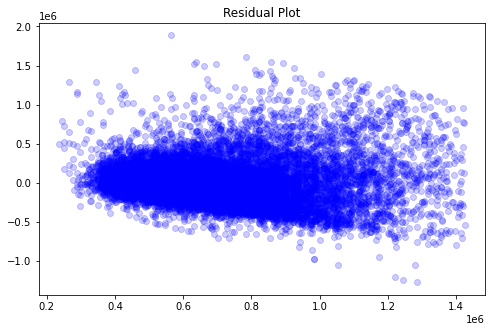

In [114]:
get_resid(df2, model2)

In [126]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg2 = linreg.fit(X_train2, y_train2)

scores2 = cross_val_score(
            linreg2, 
            X_train2,
            y_train2,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores2 = np.sqrt(-scores2)
display(rmse_scores2)
display(rmse_scores2.mean())
display(rmse_scores2.std())

array([295321.18953263, 249736.38151031, 258494.96890691, 245105.5103492 ,
       227426.37390392, 184883.81296618, 199095.84250856, 214193.43679246,
       279496.28324522, 792045.29417882])

294579.90938941936

168991.91647047078

In [127]:
summary.loc[1] = ['Simple Model - outliers removed', 'Square ft Total living', model2.df_model, round(model2.rsquared,3)\
                  , round(model2.rsquared_adj,3), int(rmse_scores2.mean()), int(rmse_scores2.std()), round((sms.jarque_bera(model2.resid)[0]),0)]

summary

,Model,Description,No. Features,R^2,Adj R^2,RMSE,RMSE sd,JB
0,Simple Model - one independent variable,Square ft Total living,1.0,0.389,0.389,398611.0,342506.0,9825842.0
1,Simple Model - outliers removed,Square ft Total living,1.0,0.354,0.354,294579.0,168991.0,7132.0


Interesting that the R-squared value reduced, but the JB number has reduced significantly, and checking the qq plot it appears to be somewhat honouring residuals normality assumption to some extent, certainly better than previously. It is not honouring the homoscedasticity assumption.

# Model 3 - Adding Features

Before adding new features, its important to check that they are have a linear relationship with SalePrice. This can be checked visually by plotting each potential feature vs SalePrice

In [132]:
# work from the dataframe that had outliers in price and sqfttotliving removed 
df3 = df2.copy()
df3.drop(columns=['Unnamed: 0'], inplace=True)

In [133]:
df3.columns

Index(['Address', 'BuildingNumber', 'DirectionPrefix', 'StreetName',
       'StreetType', 'DirectionSuffix', 'ZipCode', 'Stories', 'BldgGrade',
       'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtUpperFloor',
       'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'FinBasementGrade', 'SqFtGarageBasement', 'SqFtGarageAttached',
       'DaylightBasement', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
       'HeatSystem', 'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'YrBuilt',
       'YrRenovated', 'Condition', 'id', 'Township', 'Section',
       'QuarterSection', 'Area', 'DistrictName', 'SqFtLot', 'Access',
       'Topography', 'InadequateParking', 'MtRainier', 'Olympics', 'Cascades',
       'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington',
       'LakeSammamish', 'SmallLakeRiverCreek', 'OtherView', 'WfntLocation',
       'TrafficNoise', 'PowerLines', 'OtherNuisances', 'Adjace

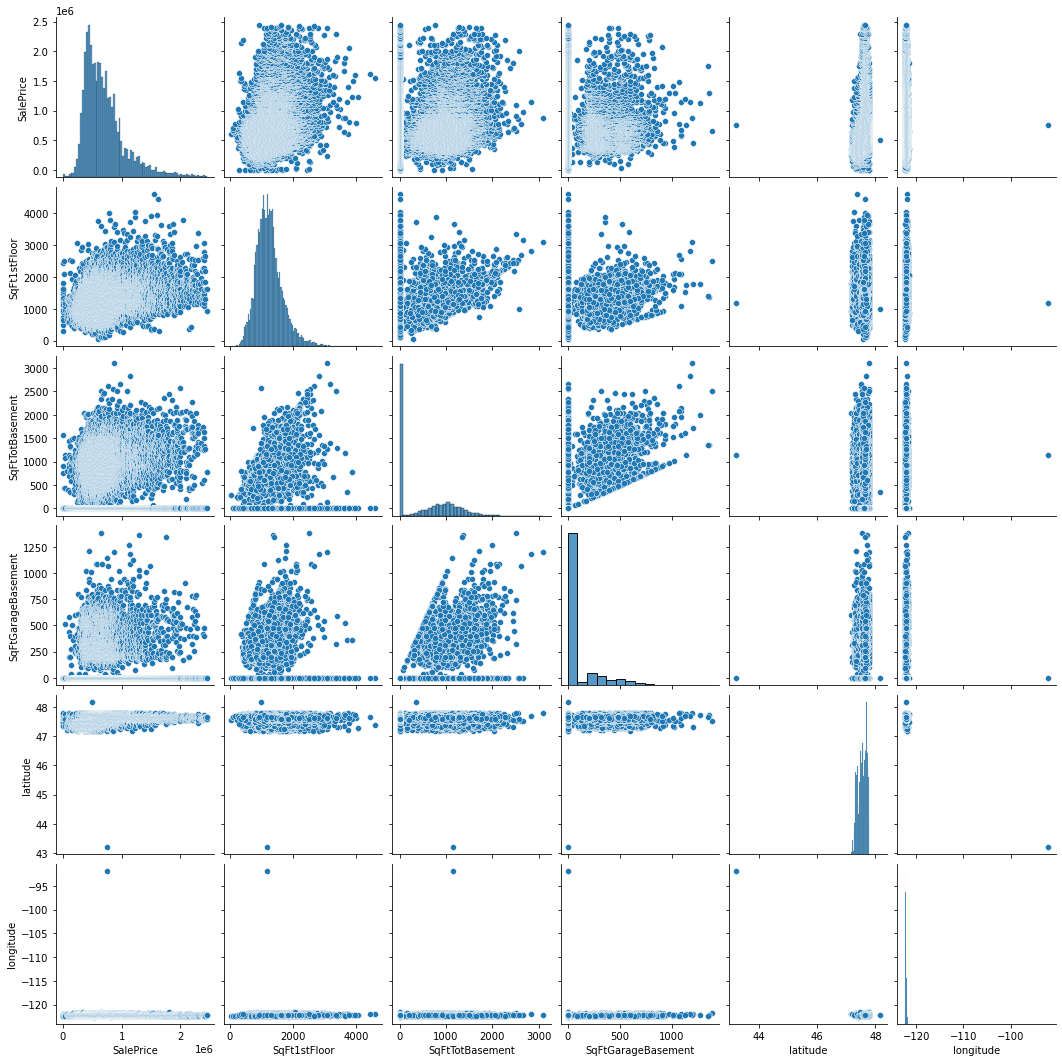

In [134]:
cont_pairplot = ['SalePrice','SqFt1stFloor','SqFtTotBasement','SqFtGarageBasement', 'latitude', 'longitude']

sns.pairplot(df3[cont_pairplot]);

These plots not very useful in their current state, however they have highlighted the need to remove further outliers..

In [135]:
df3 = drop_outliers(df3, 'latitude', 3)
df3 = drop_outliers(df3, 'longitude', 3)

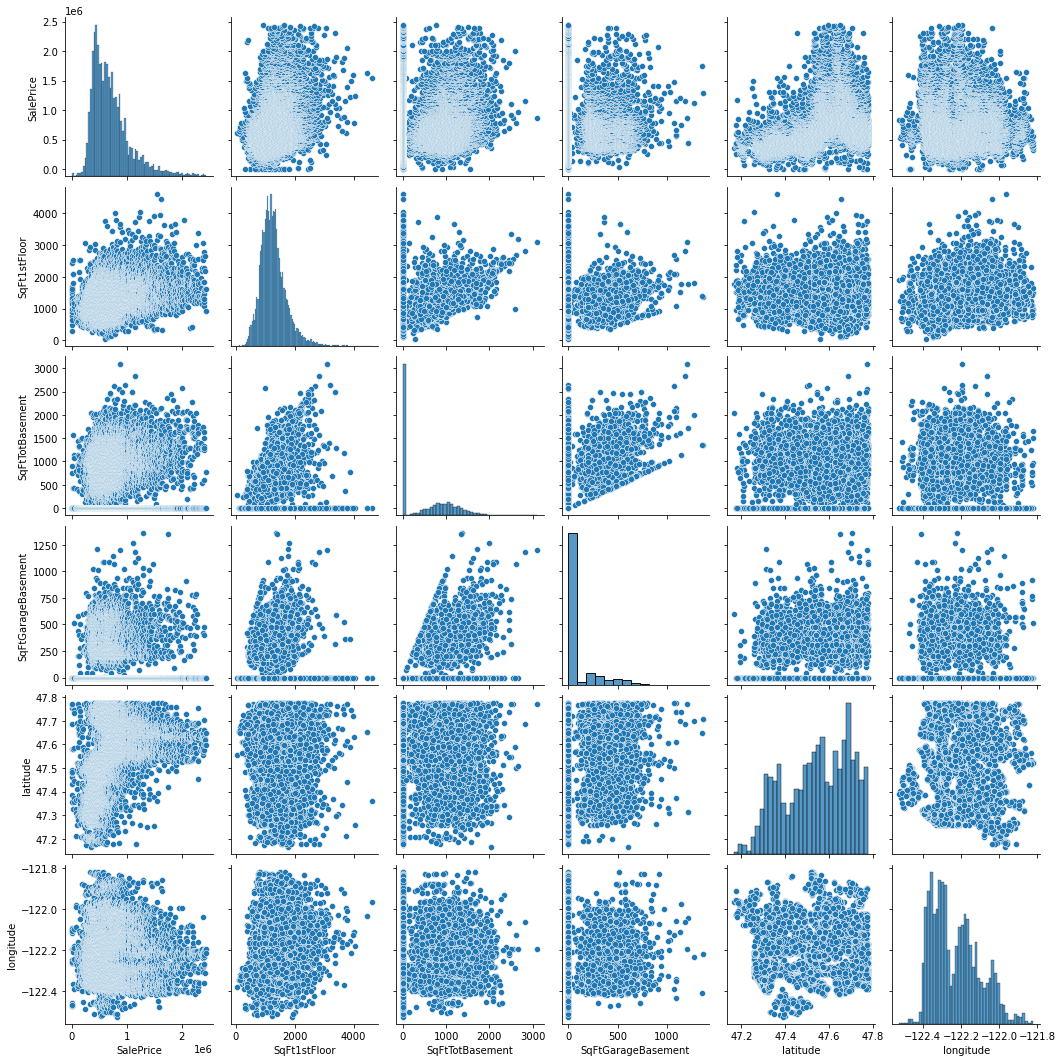

In [136]:
sns.pairplot(df3[cont_pairplot])

Messy data which is difficult to spot useful correlations but I think there are some trends particularly with SqfT1stFloor and latitude/longitude. It may be better to change some of these features into binary columns due to the high number of zeroes in each. For example SqFtGarageBasement could become (has_garagebasement).Aside from that, looking at the histograms, none of the features are normally distributed and could probably benefit from log transformation. 

In [138]:
# drop outliers from 'SqFt1stFloor'
df3 = drop_outliers(df3, 'SqFt1stFloor', 3)

In [139]:
features_3 = ['SqFtTotLiving','SqFt1stFloor', 'latitude', 'longitude']
X_train3 = df3[features_3]
y_train3 = df3['SalePrice']
X_int3 = sm.add_constant(X_train3)
model3 = sm.OLS(y_train3, X_int3).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     4327.
Date:                Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:08:04   Log-Likelihood:            -2.0765e+05
No. Observations:               15030   AIC:                         4.153e+05
Df Residuals:                   15025   BIC:                         4.154e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.291e+07   2.05e+06    -35.589      0.000   -7.69e+07   -6.89e+07
SqFtTotLiving   275.8215      3.236     85.238      0.000     269.479     282.164
SqFt1stFloor    -27.4989      6.371     -4.316      0.000     -39.988     -15.010
latitude       1.007e+06   1.37e+04     73.621      0.000     9.8e+05    1.03e+06
longitude     -2.064e+05   1.66e+04    -12.414      0.000   -2.39e+05   -1.74e+05
==============================================================================
Omnibus:                     4182.863   Durbin-Watson:                   0.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18348.360
Skew:                           1.302   Prob(JB):                         0.00
Kurtosis:                       7.746   Cond. No.                     2.56e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

C:\Users\Andrew\Documents\Flatiron\Course\phase_2\project\110920-pt-phase-2-project\useful_functions.py:66: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


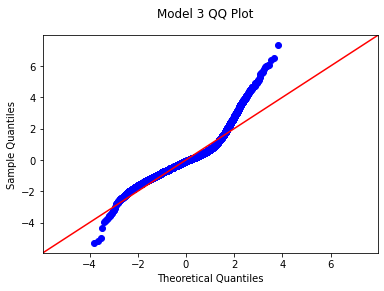

In [142]:
get_qq(model3, 'Model 3')

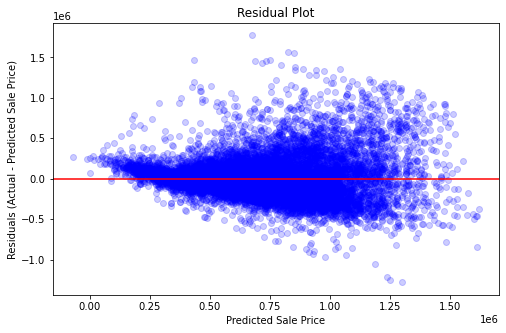

In [147]:
get_resid(df3, model3)

In [140]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg3 = linreg.fit(X_train3, y_train3)

scores3 = cross_val_score(
            linreg3, 
            X_train3,
            y_train3,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores3 = np.sqrt(-scores3)
display(rmse_scores3)
display(rmse_scores3.mean())
display(rmse_scores3.std())

array([201621.90629106, 140021.17393374, 163362.731922  , 189984.793088  ,
       202981.05367913, 195349.80303403, 183373.5191414 , 181095.90337485,
       217366.9863357 , 711475.09932703])

238663.29701269456

158954.98852596313

In [141]:
summary.loc[2] = ['Multiple Linear Model 1', 'Continuous features', model3.df_model, round(model3.rsquared,3)\
                  , round(model3.rsquared_adj,3), int(rmse_scores3.mean()), int(rmse_scores3.std()),\
                  round((sms.jarque_bera(model3.resid)[0]),0)]

summary

,Model,Description,No. Features,R^2,Adj R^2,RMSE,RMSE sd,JB
0,Simple Model - one independent variable,Square ft Total living,1.0,0.389,0.389,398611.0,342506.0,9825842.0
1,Simple Model - outliers removed,Square ft Total living,1.0,0.354,0.354,294579.0,168991.0,7132.0
2,Multiple Linear Model 1,Continuous features,4.0,0.535,0.535,238663.0,158954.0,18348.0


# Model 4 (Distance to Expensive Areas and Age Features Added)

1. Most expensive house in mercer island is in 5330 Butterworth Rd, Mercer Island, Washington
2. Most expensive house in medina is in medina 7887 Overlake Drive West
3. NE Laurelcrest Lane has the most expensive house in Seattle. 
4. Another populous area is Kent. 148th Ave SE is the most expensive neighbourhood in Kent and quite populous, I will add these four locations using Geocode

In [149]:
from geopy.geocoders import Nominatim
expensive = ['5330 Butterworth Rd, Mercer Island, Washington', '7887 Overlake Drive West, Medina, WA',\
            'NE Laurelcrest Lane, Seattle, WA', '148th Ave SE, Kent, WA']
locator = Nominatim(user_agent='myGeocoder')
for loc in expensive:
    location = locator.geocode(loc)
    print(loc)
    print('Latitude = {}, Longitude = {}'.format(location.latitude, location.longitude))

5330 Butterworth Rd, Mercer Island, Washington
Latitude = 47.55621241561222, Longitude = -122.2129871659772
7887 Overlake Drive West, Medina, WA
Latitude = 47.6160689485921, Longitude = -122.23362543624816
NE Laurelcrest Lane, Seattle, WA
Latitude = 47.6560723, Longitude = -122.2725167
148th Ave SE, Kent, WA
Latitude = 47.3844953, Longitude = -122.1426915


In [150]:
laurelcrest = [47.6560723, -122.2725167]
medina = [47.6160689485921,-122.23362543624816] 
mercer = [47.55621241561222, -122.2129871659772]
kent = [47.3844953, -122.1426915]

In [151]:
df4 = df3.copy()

In [154]:
# create column in df4 with tuple containing lat long info
df4['lat_long'] = tuple(zip(df4.latitude, df4.longitude))
# calculate distance to each of the four expensive areas highlighted and create a column for it
df4['laurelcrest'] = calc_distances(df4['lat_long'], laurelcrest, df4)
df4['medina'] = calc_distances(df4['lat_long'], medina, df4)
df4['mercer'] = calc_distances(df4['lat_long'], mercer, df4)
df4['kent'] = calc_distances(df4['lat_long'], kent, df4)

# new column with the minimum value across these four columns
df4['dist_to_exp'] = df4[['laurelcrest', 'medina', 'mercer', 'kent']].min(axis=1, numeric_only=True)

#drop the rest original 4 and work with minimum distance to an expensive area
df4.drop(['laurelcrest', 'medina', 'mercer', 'kent'], axis=1, inplace=True)

C:\Users\Andrew\anaconda3\envs\geo-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


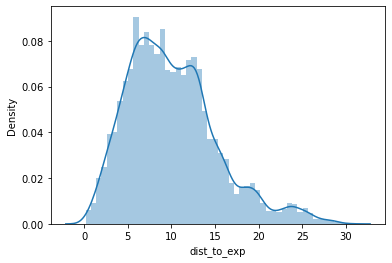

In [157]:
sns.distplot(df4.dist_to_exp);

C:\Users\Andrew\anaconda3\envs\geo-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

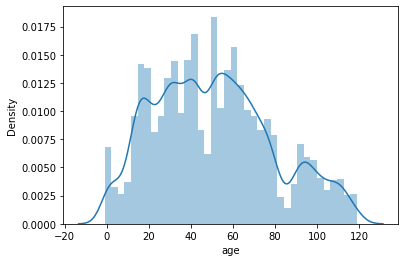

In [160]:
# create a new column for age feature
df4['age'] = 2019 - df4['YrBuilt']
sns.distplot(df4.age)

In [161]:
features_4 = ['SqFtTotLiving','SqFt1stFloor', 'latitude', 'longitude', 'dist_to_exp', 'age']
X_train4 = df4[features_4]
y_train4 = df4['SalePrice']
X_int4 = sm.add_constant(X_train4)
model4 = sm.OLS(y_train4, X_int4).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     3274.
Date:                Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                        21:57:17   Log-Likelihood:            -2.0713e+05
No. Observations:               15030   AIC:                         4.143e+05
Df Residuals:                   15023   BIC:                         4.143e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.927e+07   2.18e+06    -22.633      0.000   -5.35e+07    -4.5e+07
SqFtTotLiving   288.1086      3.320     86.790      0.000     281.602     294.615
SqFt1stFloor    -31.7000      6.287     -5.042      0.000     -44.024     -19.376
latitude       9.297e+05   1.35e+04     69.111      0.000    9.03e+05    9.56e+05
longitude     -4.327e+04   1.73e+04     -2.498      0.013   -7.72e+04   -9309.938
dist_to_exp   -1.057e+04    382.960    -27.596      0.000   -1.13e+04   -9817.377
age            1149.7452     79.533     14.456      0.000     993.850    1305.640
==============================================================================
Omnibus:                     3693.396   Durbin-Watson:                   0.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16023.068
Skew:                           1.145   Prob(JB):                         0.00
Kurtosis:                       7.510   Cond. No.                     2.82e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.82e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [162]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg4 = linreg.fit(X_train4, y_train4)

scores4 = cross_val_score(
            linreg4, 
            X_train4,
            y_train4,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores4 = np.sqrt(-scores4)
display(rmse_scores4)
display(rmse_scores4.mean())
display(rmse_scores4.std())

array([215374.88198928, 152968.68682059, 173107.84178114, 194312.91145496,
       201461.19390044, 185550.77147204, 177070.46518006, 173715.50766365,
       201522.77926357, 694540.85168871])

236962.5891214435

153473.79543835213

In [164]:
summary.loc[3] = ['Multiple Linear Model 2', 'Continuous features + age/dist_to_exp', model4.df_model, round(model4.rsquared,3)\
                  , round(model4.rsquared_adj,3), int(rmse_scores4.mean()), int(rmse_scores4.std()),\
                  round((sms.jarque_bera(model4.resid)[0]),0)]

summary

,Model,Description,No. Features,R^2,Adj R^2,RMSE,RMSE sd,JB
0,Simple Model - one independent variable,Square ft Total living,1.0,0.389,0.389,398611.0,342506.0,9825842.0
1,Simple Model - outliers removed,Square ft Total living,1.0,0.354,0.354,294579.0,168991.0,7132.0
2,Multiple Linear Model 1,Continuous features,4.0,0.535,0.535,238663.0,158954.0,18348.0
3,Multiple Linear Model 2,Continuous features + age/dist_to_exp,6.0,0.567,0.566,236962.0,153473.0,16023.0


# Model 5 - Add Binary Features

The next model I will test is one with the binary columns added to see what impact this will have.

In [165]:
df5 = df4.copy()
df5.columns

Index(['Address', 'BuildingNumber', 'DirectionPrefix', 'StreetName',
       'StreetType', 'DirectionSuffix', 'ZipCode', 'Stories', 'BldgGrade',
       'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtUpperFloor',
       'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'FinBasementGrade', 'SqFtGarageBasement', 'SqFtGarageAttached',
       'DaylightBasement', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
       'HeatSystem', 'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'YrBuilt',
       'YrRenovated', 'Condition', 'id', 'Township', 'Section',
       'QuarterSection', 'Area', 'DistrictName', 'SqFtLot', 'Access',
       'Topography', 'InadequateParking', 'MtRainier', 'Olympics', 'Cascades',
       'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington',
       'LakeSammamish', 'SmallLakeRiverCreek', 'OtherView', 'WfntLocation',
       'TrafficNoise', 'PowerLines', 'OtherNuisances', 'Adjace

In [177]:
# engineer column for traffic noise
df5.loc[df5['TrafficNoise']!= 0, 'TrafficNoise'] = 1

# engineer a column for has_basement
df5['has_basement'] = 0
df5.loc[(df5['SqFtGarageBasement']!= 0)|(df5['SqFtTotBasement']!= 0)|\
        (df5['DaylightBasement']!= 0), 'has_basement'] = 1

# engineer a column for has_deck
df5['has_deck'] = 0
df5.loc[(df5['SqFtDeck']!= 0),'has_deck'] = 1

# engineer a column for has_porch
df5['has_porch'] = 0
df5.loc[(df5['SqFtOpenPorch']!= 0)|(df5['SqFtEnclosedPorch']!= 0), 'has_porch'] = 1

# engineer a column for has_renovation
df5['has_renovation'] = 0
df5.loc[df5['YrRenovated'] != 0, 'has_renovation'] = 1

# engineer a column for has_problem
df5['has_problem'] = 0
df5.loc[(df5['PowerLines'] != 0)|(df5['OtherNuisances'] != 0), 'has_problem'] = 1


In [181]:
binary_cols5 = ['AdjacentGreenbelt','excellent_view','Topography', 'InadequateParking', 'MtRainier',\
               'Olympics', 'Cascades','Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington','LakeSammamish',\
               'SmallLakeRiverCreek', 'OtherView', 'WfntLocation', 'Easements', 'SaleWarning', 'ViewUtilization',
               'has_porch', 'has_renovation', 'has_basement', 'TrafficNoise', 'has_problem']

cont_5 = ['SqFtTotLiving','SqFt1stFloor', 'latitude', 'longitude', 'dist_to_exp', 'age']

In [184]:
features_5 = binary_cols5 + cont_5
X_train5 = df5[features_5]
y_train5 = df5['SalePrice']
X_int5 = sm.add_constant(X_train5)
model5 = sm.OLS(y_train5, X_int5).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.622
Method:                 Least Squares   F-statistic:                     852.7
Date:                Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                        22:29:28   Log-Likelihood:            -2.0609e+05
No. Observations:               15030   AIC:                         4.122e+05
Df Residuals:                   15000   BIC:                         4.125e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -4.473e+07   2.19e+06    -20.387      0.000    -4.9e+07   -4.04e+07
AdjacentGreenbelt    1.538e+04   1.18e+04      1.308      0.191   -7662.162    3.84e+04
excellent_view        1.13e+05   1.93e+04      5.853      0.000    7.52e+04    1.51e+05
Topography           1.856e+04   6930.618      2.677      0.007    4971.100    3.21e+04
InadequateParking    3.499e+04   3690.286      9.482      0.000    2.78e+04    4.22e+04
MtRainier            7.174e+04   2.15e+04      3.342      0.001    2.97e+04    1.14e+05
Olympics             7.625e+04    1.6e+04      4.775      0.000    4.49e+04    1.08e+05
Cascades            -6411.7770   1.32e+04     -0.485      0.627   -3.23e+04    1.95e+04
Territorial          5629.9652   9303.120      0.605      0.545   -1.26e+04    2.39e+04
SeattleSkyline       1.806e+05   2.13e+04      8.482      0.000    1.39e+05    2.22e+05
PugetSound           9.376e+04   1.44e+04      6.503      0.000    6.55e+04    1.22e+05
LakeWashington       1.588e+05    1.4e+04     11.338      0.000    1.31e+05    1.86e+05
LakeSammamish        3.203e+05   2.85e+04     11.239      0.000    2.64e+05    3.76e+05
SmallLakeRiverCreek -3.239e+04   2.64e+04     -1.229      0.219   -8.41e+04    1.93e+04
OtherView             1.02e+05   3.15e+04      3.234      0.001    4.02e+04    1.64e+05
WfntLocation         2.695e+05   2.38e+04     11.321      0.000    2.23e+05    3.16e+05
Easements            2.628e+04   1.32e+04      1.985      0.047     335.462    5.22e+04
SaleWarning         -1.038e+05   7446.043    -13.945      0.000   -1.18e+05   -8.92e+04
ViewUtilization      1.977e+05   1.39e+04     14.211      0.000     1.7e+05    2.25e+05
has_porch            4.345e+04   3772.634     11.516      0.000    3.61e+04    5.08e+04
has_renovation       5.696e+04   8279.590      6.880      0.000    4.07e+04    7.32e+04
has_basement        -1.747e+04   4306.812     -4.057      0.000   -2.59e+04   -9030.786
TrafficNoise        -3.003e+04   5205.521     -5.769      0.000   -4.02e+04   -1.98e+04
has_problem         -2.974e+04   9259.612     -3.211      0.001   -4.79e+04   -1.16e+04
SqFtTotLiving         251.4487      3.557     70.700      0.000     244.477     258.420
SqFt1stFloor          -16.5864      6.160     -2.693      0.007     -28.661      -4.512
latitude             9.458e+05   1.28e+04     73.632      0.000    9.21e+05    9.71e+05
longitude            -103.5302   1.75e+04     -0.006      0.995   -3.43e+04    3.41e+04
dist_to_exp         -1.147e+04    371.311    -30.882      0.000   -1.22e+04   -1.07e+04
age                   922.0280     81.847     11.265      0.000     761.598    1082.458
==============================================================================
Omnibus:                     3390.296   Durbin-Watson:                   1.049
Prob(Omnibus):       

In [185]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg5 = linreg.fit(X_train5, y_train5)

scores5 = cross_val_score(
            linreg5, 
            X_train5,
            y_train5,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores5 = np.sqrt(-scores5)
display(rmse_scores5)
display(rmse_scores5.mean())
display(rmse_scores5.std())

array([209955.6801617 , 142784.92231253, 162558.27142548, 181399.6617275 ,
       188908.94376808, 176733.07227389, 170209.56608749, 171807.44077743,
       205131.39188023, 663269.84225369])

227275.879266802

146517.14238741784

C:\Users\Andrew\Documents\Flatiron\Course\phase_2\project\110920-pt-phase-2-project\useful_functions.py:66: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


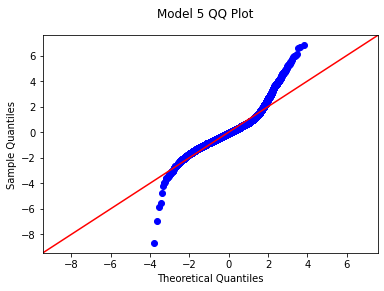

In [188]:
get_qq(model5, 'Model 5')

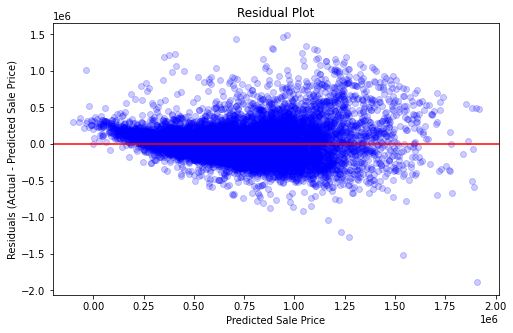

In [187]:
get_resid(df5, model5)

In [186]:
summary.loc[4] = ['Multiple Linear Model 3', 'continuous + binary features', model5.df_model, round(model5.rsquared,3)\
                  , round(model5.rsquared_adj,3), int(rmse_scores5.mean()), int(rmse_scores5.std()),\
                  round((sms.jarque_bera(model5.resid)[0]),0)]

summary

,Model,Description,No. Features,R^2,Adj R^2,RMSE,RMSE sd,JB
0,Simple Model - one independent variable,Square ft Total living,1.0,0.389,0.389,398611.0,342506.0,9825842.0
1,Simple Model - outliers removed,Square ft Total living,1.0,0.354,0.354,294579.0,168991.0,7132.0
2,Multiple Linear Model 1,Continuous features,4.0,0.535,0.535,238663.0,158954.0,18348.0
3,Multiple Linear Model 2,Continuous features + age/dist_to_exp,6.0,0.567,0.566,236962.0,153473.0,16023.0
4,Multiple Linear Model 3,continuous + binary features,29.0,0.622,0.622,227275.0,146517.0,16416.0


# Model 6 - Adding Categorical Features

ok now it is time to add further categorical features, however, we will need to onehotencode them first. 

In [189]:
df5.columns

Index(['Address', 'BuildingNumber', 'DirectionPrefix', 'StreetName',
       'StreetType', 'DirectionSuffix', 'ZipCode', 'Stories', 'BldgGrade',
       'SqFt1stFloor', 'SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtUpperFloor',
       'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'FinBasementGrade', 'SqFtGarageBasement', 'SqFtGarageAttached',
       'DaylightBasement', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
       'HeatSystem', 'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'YrBuilt',
       'YrRenovated', 'Condition', 'id', 'Township', 'Section',
       'QuarterSection', 'Area', 'DistrictName', 'SqFtLot', 'Access',
       'Topography', 'InadequateParking', 'MtRainier', 'Olympics', 'Cascades',
       'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington',
       'LakeSammamish', 'SmallLakeRiverCreek', 'OtherView', 'WfntLocation',
       'TrafficNoise', 'PowerLines', 'OtherNuisances', 'Adjace

In [198]:
features_6 = ['AdjacentGreenbelt', 'excellent_view', 'Topography', 'InadequateParking', 'MtRainier', 'Olympics', 'Cascades',\
               'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek',\
               'OtherView', 'WfntLocation', 'Easements', 'SaleWarning', 'ViewUtilization', 'has_porch', 'has_renovation',\
              'has_basement', 'TrafficNoise', 'has_problem', 'SqFtTotLiving', 'SqFt1stFloor', 'latitude', 'longitude',\
               'dist_to_exp', 'age', 'SalePrice']

Prior to adding in ZipCodes into the analysis, I will have a quick QC of the values. I don't think including zips with few entries will be valuable

In [234]:
df6 = df5.copy()
df6.ZipCode.value_counts()

98042         521
98023         499
98058         443
98115         414
98038         403
98034         392
98117         383
98001         342
98118         337
98103         335
98052         331
98133         322
98155         304
98059         296
98006         294
98033         275
98003         273
98056         273
98106         272
98092         270
98031         268
98126         266
98074         265
98125         263
98168         253
98116         237
98178         231
98198         226
98146         219
98199         217
98177         212
98002         211
98008         207
98022         207
98028         202
98030         197
98122         196
98053         195
98144         194
98027         192
98055         183
98075         182
98105         181
98040         180
98136         178
98112         177
98166         171
98072         170
98107         157
98029         155
98108         151
98011         150
98077         132
98032         124
98119         121
98004     

In [235]:
zips_to_keep = ['98042', '98023', '98058', '98117', '98115', '98034', '98038', '98133',
       '98001', '98118', '98103', '98155', '98052', '98003', '98031', '98059',
       '98125', '98056', '98168', '98106', '98126', '98092', '98146', '98198',
       '98006', '98178', '98116', '98002', '98033', '98030', '98074', '98022',
       '98177', '98008', '98028', '98055', '98122', '98144', '98199', '98136',
       '98045', '98107', '98072', '98108', '98166', '98011', '98029', '98027',
       '98053', '98105', '98188', '98112', '98032', '98065', '98075', '98119',
       '98019', '98077', '98007', '98070', '98014', '98040', '98148', '98005',
       '98109', '98004', '98102', '98024', '98010', '98047', '98051']

In [236]:
df6 = df6[df6['ZipCode'].isin(zips_to_keep)]

In [241]:
categoricals6 = ['HeatSystem', 'HeatSource', 'Access', 'ZipCode', 'Condition', 'Bedrooms', 'BldgGrade']

cat6_ohe = df6[categoricals6]
encoder = OneHotEncoder(drop='first', sparse=False)
encoder.fit(cat6_ohe)
cat6_ohe = encoder.transform(cat6_ohe)
cat6_ohe = pd.DataFrame(cat6_ohe, columns = encoder.get_feature_names())
cont6 = df6[features_6]
cat6_ohe.reset_index(drop=True, inplace=True)
cont6.reset_index(drop=True, inplace=True)
preprocessed6 = pd.concat([cont6, cat6_ohe], axis=1)
X_train6 = preprocessed6.drop('SalePrice', axis=1)
y_train6 = preprocessed6['SalePrice']

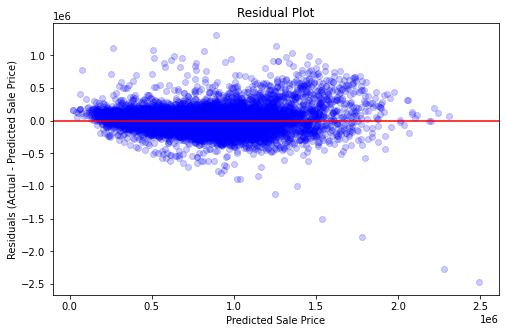

In [245]:
get_resid(preprocessed6, model6)

C:\Users\Andrew\Documents\Flatiron\Course\phase_2\project\110920-pt-phase-2-project\useful_functions.py:66: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


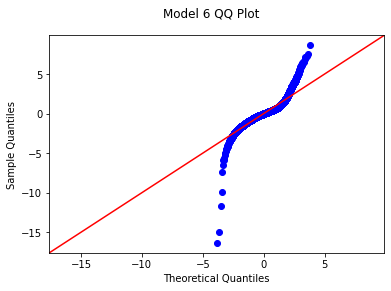

In [246]:
get_qq(model6, 'Model 6')

In [242]:
X_int6 = sm.add_constant(X_train6)
model6 = sm.OLS(y_train6, X_int6).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     474.0
Date:                Thu, 04 Mar 2021   Prob (F-statistic):               0.00
Time:                        23:48:23   Log-Likelihood:            -1.9993e+05
No. Observations:               14980   AIC:                         4.001e+05
Df Residuals:                   14840   BIC:                         4.012e+05
Df Model:                         139                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -9.809e+05   8.22e+06     -0.119      0.905   -1.71e+07    1.51e+07
AdjacentGreenbelt    -2184.8460   8457.549     -0.258      0.796   -1.88e+04    1.44e+04
excellent_view        1.383e+05   1.36e+04     10.140      0.000    1.12e+05    1.65e+05
Topography           -1.224e+04   4986.125     -2.455      0.014    -2.2e+04   -2469.078
InadequateParking    -8996.6520   3240.568     -2.776      0.006   -1.53e+04   -2644.737
MtRainier            -1.718e+04   1.53e+04     -1.125      0.260   -4.71e+04    1.27e+04
Olympics              5.293e+04   1.14e+04      4.625      0.000    3.05e+04    7.54e+04
Cascades              8032.4087   9406.227      0.854      0.393   -1.04e+04    2.65e+04
Territorial          -2587.3475   6586.966     -0.393      0.694   -1.55e+04    1.03e+04
SeattleSkyline        9.377e+04   1.52e+04      6.171      0.000     6.4e+04    1.24e+05
PugetSound            7.019e+04   1.04e+04      6.769      0.000    4.99e+04    9.05e+04
LakeWashington         1.65e+05   1.01e+04     16.292      0.000    1.45e+05    1.85e+05
LakeSammamish         1.684e+05    2.1e+04      8.018      0.000    1.27e+05     2.1e+05
SmallLakeRiverCreek  -3.776e+04   1.87e+04     -2.015      0.044   -7.45e+04   -1031.098
OtherView            -4.678e+04   2.26e+04     -2.071      0.038   -9.11e+04   -2509.884
WfntLocation          2.624e+05   1.71e+04     15.316      0.000    2.29e+05    2.96e+05
Easements             2.551e+04   9495.370      2.687      0.007    6899.282    4.41e+04
SaleWarning          -1.068e+05   5316.260    -20.086      0.000   -1.17e+05   -9.64e+04
ViewUtilization        7.53e+04      1e+04      7.496      0.000    5.56e+04     9.5e+04
has_porch             2.133e+04   2690.030      7.931      0.000    1.61e+04    2.66e+04
has_renovation            7e+04   6037.834     11.594      0.000    5.82e+04    8.18e+04
has_basement          -1.51e+04   3161.615     -4.775      0.000   -2.13e+04   -8899.337
TrafficNoise         -3.291e+04   3682.486     -8.936      0.000   -4.01e+04   -2.57e+04
has_problem          -2.255e+04   6591.810     -3.421      0.001   -3.55e+04   -9627.776
SqFtTotLiving          156.0752      3.408     45.792      0.000     149.394     162.756
SqFt1stFloor            14.1965      4.744      2.992      0.003       4.897      23.496
latitude               1.31e+05   6.79e+04      1.929      0.054   -2106.945    2.64e+05
longitude             3.687e+04   6.43e+04      0.574      0.566   -8.91e+04    1.63e+05
dist_to_exp          -9278.2377    852.469    -10.884      0.000   -1.09e+04   -7607.293
age                    281.0426     72.975      3.851      0.000     138.003     424.082
x0_Floor-Wall        -1886.9287   9002.708     -0.210      0.834   -1.95e+04    1.58e+04
x0_Forced Air         2737.4482   6495.512      0.421    

In [243]:
# I will now check run the model using sk-learn
linreg = LinearRegression()

# Fit on training data
linreg6 = linreg.fit(X_train6, y_train6)

scores6 = cross_val_score(
            linreg6, 
            X_train6,
            y_train6,
            cv=10,
            scoring="neg_mean_squared_error"
)

rmse_scores6 = np.sqrt(-scores6)
display(rmse_scores6)
display(rmse_scores6.mean())
display(rmse_scores6.std())

array([187165.76612223,  95201.47920293,  92223.77021711, 105275.92555318,
       125961.47105437, 122146.37209557, 128926.18138758, 141953.59817183,
       158452.64936749, 512208.35599718])

166951.55691694707

118312.22299791012

In [244]:
summary.loc[5] = ['Multiple Linear Model 4', 'continuous + binary features + cat', model6.df_model, round(model6.rsquared,3)\
                  , round(model6.rsquared_adj,3), int(rmse_scores6.mean()), int(rmse_scores6.std()),\
                  round((sms.jarque_bera(model6.resid)[0]),0)]

summary

,Model,Description,No. Features,R^2,Adj R^2,RMSE,RMSE sd,JB
0,Simple Model - one independent variable,Square ft Total living,1.0,0.389,0.389,398611.0,342506.0,9825842.0
1,Simple Model - outliers removed,Square ft Total living,1.0,0.354,0.354,294579.0,168991.0,7132.0
2,Multiple Linear Model 1,Continuous features,4.0,0.535,0.535,238663.0,158954.0,18348.0
3,Multiple Linear Model 2,Continuous features + age/dist_to_exp,6.0,0.567,0.566,236962.0,153473.0,16023.0
4,Multiple Linear Model 3,continuous + binary features,29.0,0.622,0.622,227275.0,146517.0,16416.0
5,Multiple Linear Model 4,continuous + binary features + cat,139.0,0.816,0.814,166951.0,118312.0,165256.0


The JB metric on this model has increased by an order of magnitude and its clear from the qq plot that the normality of residuals assumption is not being met, there could also be strong multicollinearity at play. I will work to try and improve this model both in terms of R^2 but more importantly the JB number to provide confidence in the results. 

In [248]:
# check for highly correlated features
get_multicol(preprocessed6)

,cc
pairs,
"(x2_PUBLIC, x2_PRIVATE)",0.985493
"(x4_4, x4_3)",0.748812


Ok so two dummy variables are highly correlated, this would lead me to suspect the variable being dropped when onehotencoding has a relatively low count. It may be worse removing these rows from the analysis for the next model. 

In [249]:
get_multicol(df6)

,cc
pairs,
"(age, YrBuilt)",1.000000
"(has_renovation, YrRenovated)",0.999959
"(latitude, Township)",0.984267
"(has_basement, SqFtTotBasement)",0.882418
"(OtherNuisances, has_problem)",0.846419
"(FinBasementGrade, SqFtFinBasement)",0.845789
"(SqFtFinBasement, SqFtTotBasement)",0.837436
"(Stories, SqFt2ndFloor)",0.824724
"(has_basement, FinBasementGrade)",0.822696


# Model 7 - Cleaning features, adding SqFt2ndFloor